 **Creating anime characters using Deep Convolutional Generative Adversarial Networks (DCGANs) and Keras**

## Setup


For this lab, we will be using the following libraries:

*   [`pandas`](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for managing the data.
*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`sklearn`](https://scikit-learn.org/stable/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and machine-learning-pipeline related functions.
*   [`seaborn`](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for visualizing the data.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.
*   [`keras`](https://keras.io/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for loading datasets.
*   [`tensorflow`](https://www.tensorflow.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for machine learning and neural network related functions.




### Installing Required Libraries

In [1]:
!pip install -qy pandas==1.3.4 numpy==1.21.4 seaborn==0.9.0 matplotlib==3.5.0 scikit-learn==0.20.1


Usage:   
  pip3 install [options] <requirement specifier> [package-index-options] ...
  pip3 install [options] -r <requirements file> [package-index-options] ...
  pip3 install [options] [-e] <vcs project url> ...
  pip3 install [options] [-e] <local project path> ...
  pip3 install [options] <archive url/path> ...

no such option: -y


In [2]:
!pip install -q tqdm

In [3]:
!pip3 install -q --upgrade tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.2 MB/s eta 0:00:00


Run the following upgrade and then **RESTART YOUR KERNEL**. Make sure the version of tensorflow imported below is **no less than 2.9.0**.


### Importing Required Libraries

In [4]:
!pip install -q skillsnetwork

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 34.1 MB/s eta 0:00:00


In [5]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
print(f"tensorflow version: {tf.__version__}")
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2DTranspose,BatchNormalization,ReLU,Conv2D,LeakyReLU
import time

import keras

from IPython import display
import skillsnetwork
print(f"skillsnetwork version: {skillsnetwork.__version__}")

import matplotlib.pyplot as plt
%matplotlib inline

import os
from os import listdir
from pathlib import Path
import imghdr

from tqdm import tqdm

tensorflow version: 2.15.0
skillsnetwork version: 0.20.6


### Defining Helper Functions

In [6]:
# This function will allow us to easily plot data taking in x values, y values, and a title
def plot_distribution(real_data,generated_data,discriminator=None,density=True):

    plt.hist(real_data.numpy(), 100, density=density, facecolor='g', alpha=0.75, label='real data')
    plt.hist(generated_data.numpy(), 100, density=density, facecolor='r', alpha=0.75,label='generated data q(z) ')

    if discriminator:
        max_=np.max([int(real_data.numpy().max()),int(generated_data.numpy().max())])
        min_=np.min([int(real_data.numpy().min()),int(generated_data.numpy().min())])
        x=np.linspace(min_, max_, 1000).reshape(-1,1)
        plt.plot(x,tf.math.sigmoid(discriminator(x,training=False).numpy()),label='discriminator',color='k')
        plt.plot(x,0.5*np.ones(x.shape),label='0.5',color='b')
        plt.xlabel('x')

    plt.legend()
    plt.show()

def plot_array(X,title=""):

    plt.rcParams['figure.figsize'] = (20,20)

    for i,x in enumerate(X[0:5]):
        x=x.numpy()
        max_=x.max()
        min_=x.min()
        xnew=np.uint(255*(x-min_)/(max_-min_))
        plt.subplot(1,5,i+1)
        plt.imshow(xnew)
        plt.axis("off")

    plt.show()

### Toy Data

Consider the following data, $\mathbf{x}$, that is normally distributed $\mathbf{x} \sim \mathcal{N}(\mathbf{x}|10,1) $ with a mean of 10 and a standard deviation of 1. Now we would like to randomly sample data from this distribution.


In [7]:
mean = [10]
cov = [[1]]
X = tf.random.normal((5000,1),mean=10,stddev=1.0)

print("mean:",np.mean(X))
print("standard deviation:",np.std(X))

mean: 9.995368
standard deviation: 0.99112064


We also have the data sample, z, which is also normally distributed $\mathbf{z} \sim \mathcal{N}(\mathbf{z}|0,2) $, with mean of 0 and a standard deviation of 2:



In [8]:
Z = tf.random.normal((5000,1),mean=0,stddev=2)

In [9]:
print("mean:",np.mean(Z))
print("standard deviation:",np.std(Z))

mean: -0.056983344
standard deviation: 2.0182993


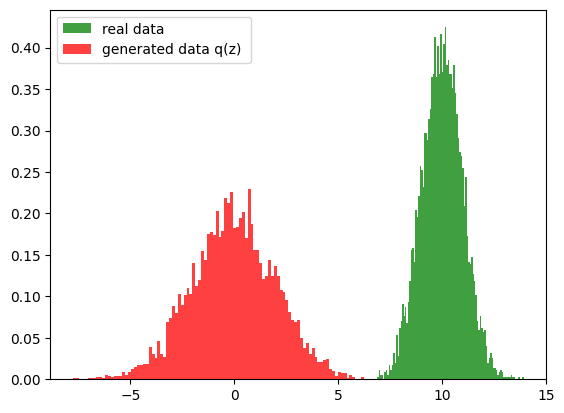

In [10]:
plot_distribution(X,Z,discriminator=None,density=True)

Let's create our first generative model by adding 10 to every sample of $z$. We will call the result $\hat{\mathbf{x}}$  as it's an approximation of $\mathbf{x}$. It is not too difficult to show that $\hat{\mathbf{x}} \sim \mathcal{N}(\mathbf{x}|10,1)$.Xhat=Z+10


In [11]:
Xhat=Z+10

We see that the mean and standard deviation are almost identical


In [12]:
print("mean:",np.mean(Xhat))
print("standard deviation:",np.std(Xhat))

mean: 9.943017
standard deviation: 2.0182993


Similarly for the histograms


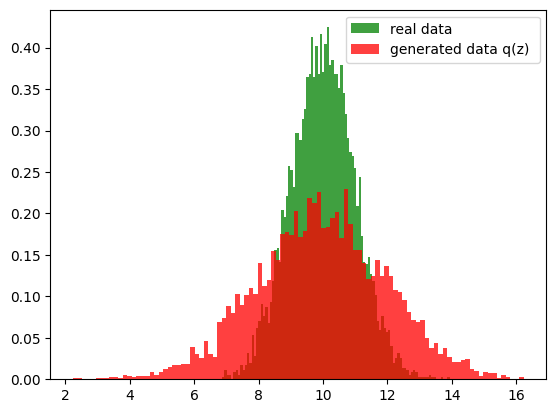

In [13]:
plot_distribution(X,Xhat,discriminator=None,density=True)

### The Generator


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/images/Unknown.png" width="300px">

There are two networks involved in a GAN, the Generator and the Discriminator. Let's understand the Generator network first.

The Generator is a neural network denoted by $G$; the idea is that a neural network can approximate any function (by the [Universal Approximation Theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0XCEEN72-2022-01-01)), so you should be able to generate data samples from any type of distribution.

Our goal is to convert the samples, $\mathbf{z}$, to one that approximates $\hat{\mathbf{x}}$,  i.e $\hat{\mathbf{x}}=G(\mathbf{z})$. Let's build a simple Generator $G(\mathbf{z})=\mathbf{W}^{T}\mathbf{z}+\mathbf{b} $ using Keras.

The following is a function that outputs a generator using Kera's Sequential model object.


In [14]:
def make_generator_model():
    generator = tf.keras.Sequential()
    generator.add(layers.Dense(1))
    return generator

We can use the Generator to convert $\mathbf{z}$ and make a prediction $\hat{\mathbf{x}}$, and display the histogram of the distributions of $\hat{\mathbf{x}}$ and $\mathbf{x}$. As the model is not trained, the trained distributions are quite different:


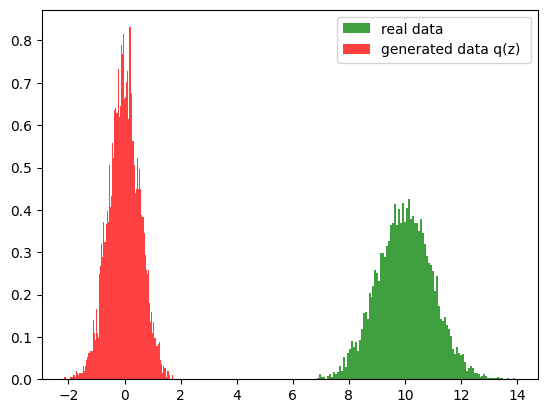

In [15]:
generator=make_generator_model()

Xhat = generator(Z, training=False)
plot_distribution(real_data=X,generated_data=Xhat)

### The Discriminator


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/images/Unknown1.png" width="300px">

The discriminator $D(\mathbf{x})$ is a neural network that learns to distinguish between actual and generated samples. The simplest Discriminator is a simple logistic regression function. Let's create a discriminator in Keras with one Dense layer; we leave the logistic function out as it will be incorporated in the cost function, which is the convention in Keras.


In [16]:
def make_discriminator_model():
    discriminator=tf.keras.Sequential()
    discriminator.add(layers.Dense(1))
    return discriminator

discriminator=make_discriminator_model()

The discriminator and generator are randomly initialized, but we can plot the output of each and compare it to the true data distribution, with the generated data in red and the real data in green, and the logistic function as a function of the x axis. We also include the threshold. If the output of the logistic function is less than 0.5, the sample is classified as generated data; conversely, if the output is greater than 0.5, the sample will be classified as data that came from the real distribution.


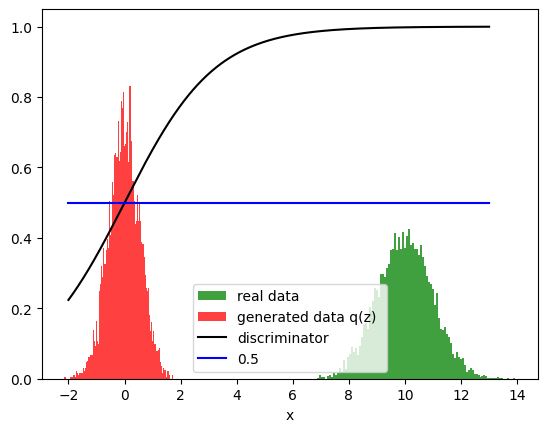

In [17]:
plot_distribution(real_data=X,generated_data=Xhat,discriminator=discriminator)

Applying the sigmoid function to the discriminator output, we get the probabilites that the samples belong to the real distribution. We can count the number of true samples that the discriminator correctly classifies.

For the real data, the discriminator successfully assigns a probability greater than 0.5 for all 5000 samples:


In [18]:
py_x=tf.math.sigmoid(discriminator(X,training=False))
np.sum(py_x>0.5)

5000

For the generated data, only a part of the 5000 samples are classified as having more than 50% chance of coming from the real distribution.


In [19]:
py_x=discriminator(Xhat)
np.sum(py_x>0.5)

357

We can also use the following to find the average value of the sigmoid function for all the samples.  


In [20]:
def get_accuracy(X,Xhat):
    total=0
    py_x=tf.math.sigmoid(discriminator(X,training=False))
    total=np.mean(py_x)
    py_x=tf.math.sigmoid(discriminator(Xhat,training=False))
    total+=np.mean(py_x)
    return total/2

In [21]:
get_accuracy(X,Xhat)

0.7476373910903931

In many cases, we can instead study the difference in the distribution; in this case, the discriminator is called a <a href='https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/papers/2107.06700.pdf'>Critic</a>, a real-valued function.


We can also use the following to find the average value of the sigmoid function for all the samples.  


In [22]:
def get_accuracy(X,Xhat):
    total=0
    py_x=tf.math.sigmoid(discriminator(X,training=False))
    total=np.mean(py_x)
    py_x=tf.math.sigmoid(discriminator(Xhat,training=False))
    total+=np.mean(py_x)
    return total/2

In [23]:
get_accuracy(X,Xhat)

0.7476373910903931

We can also use the following to find the average value of the sigmoid function for all the samples.  


### Training GANs

GANs are quite difficult to train, even for a simple example. Let's start off with training the generator in practice.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/images/unknown3.jpeg" width="500px">

___Training Generator___

$log(1 − D(G(\mathbf{z})))$ is difficult to work with as $D(G(\mathbf{z}))$ is near one or zero for the first few iterations. This is because the generator is not yet properly trained, and the discriminator can easily distinguish between the generated and actual samples. Therefore we maximize $log(D(G(\mathbf{z}_k)) )$.

Although the output of the generator passes through the discriminator, we do not update the generator in the optimization step, hence we set the parameter ```training=False``` in the actual training steps.


Instead of maximizing the term, we can take the negative and minimize it. The resultant expression can be calculated in Keras using the cross-entropy loss where all the target values are set to one:

$$\sum_{k 	\notin \mathcal{D}} log(1 - D(G(\mathbf{z}_k)) )$$


In [24]:
# This method returns a helper function to compute crossentropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

___Training Discriminator___

We can also use the cross-entropy to train the discriminator; we simply multiply $V(G,D)$ by a negative number, set $y=0$ for the generated values and $y=1$ for the real values. We do not update the generator parameters.

$$V(G)=\sum_{n	\in \mathcal{D}} (\ln(D(\mathbf{x}_n)))+\sum_{k 	\notin \mathcal{D}} \ln(1-D(G(\mathbf{z}_k) )) $$


In [25]:
def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

In [26]:
generator_optimizer = tf.keras.optimizers.Adam(5e-1,beta_1=0.5,beta_2=0.8)

discriminator_optimizer = tf.keras.optimizers.Adam(5e-1,beta_1=0.5, beta_2=0.8)

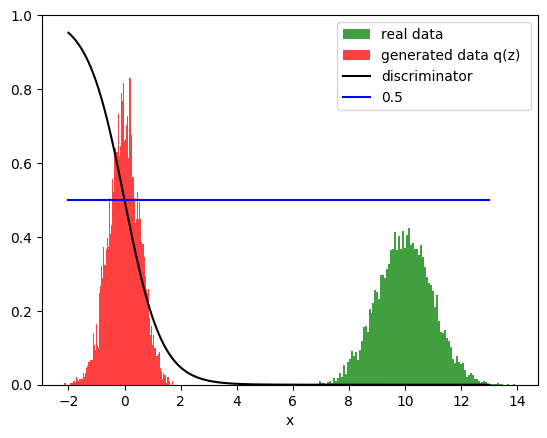

epoch 0


  0%|          | 0/20 [00:00<?, ?it/s]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


0.2742231488227844


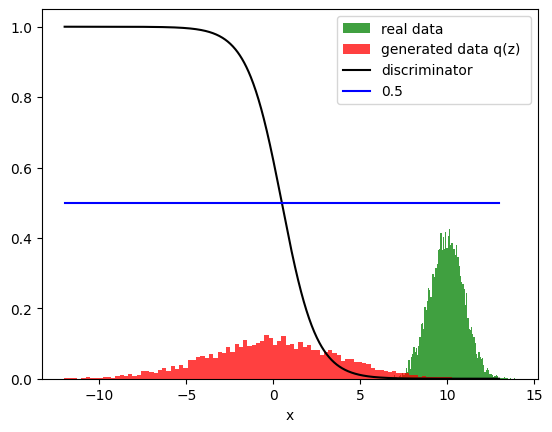

  5%|▌         | 1/20 [00:03<01:02,  3.30s/it]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


epoch 0


0.38488689064979553


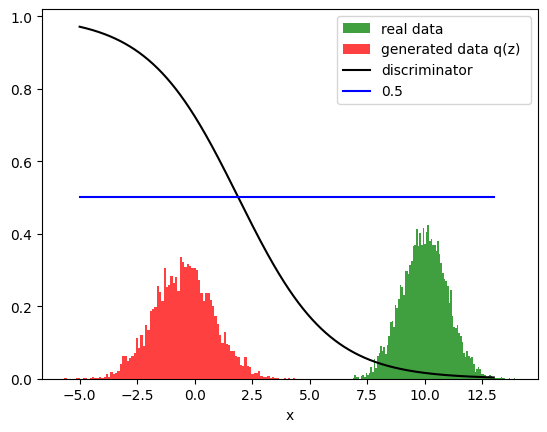

 15%|█▌        | 3/20 [00:05<00:23,  1.39s/it]

epoch 1


 60%|██████    | 12/20 [00:05<00:01,  6.64it/s]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


0.5970597267150879


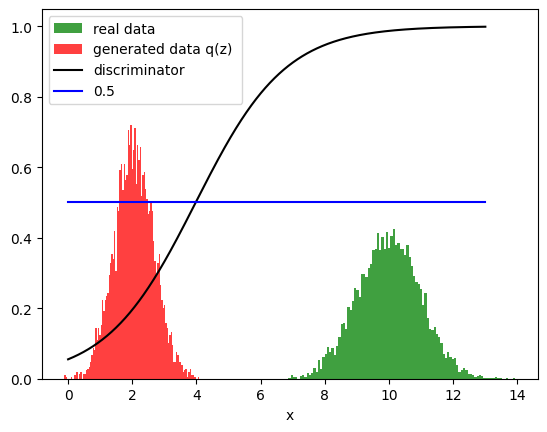

epoch 12


0.535872220993042


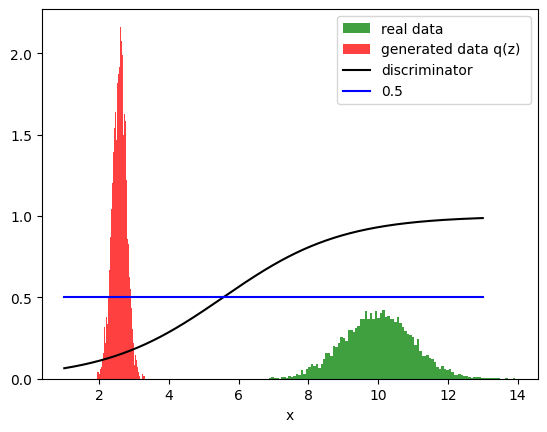

 70%|███████   | 14/20 [00:09<00:04,  1.42it/s]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


epoch 13


0.482372909784317


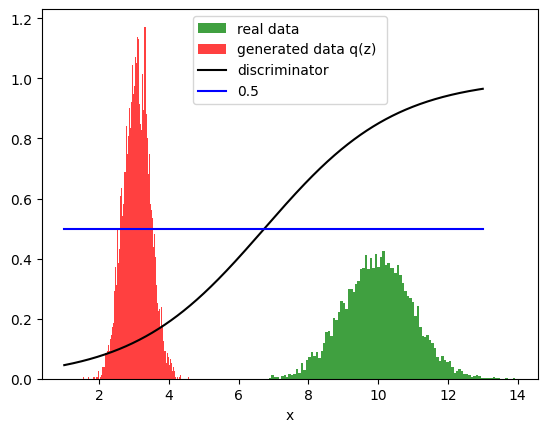

 75%|███████▌  | 15/20 [00:12<00:05,  1.05s/it]

epoch 14


 85%|████████▌ | 17/20 [00:12<00:02,  1.43it/s]WARNING:tensorflow:Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


0.5031749606132507


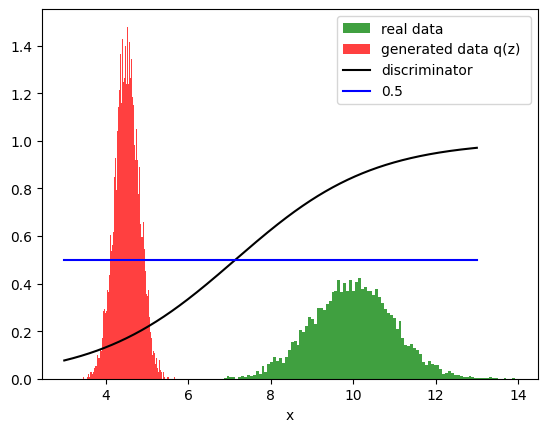

 90%|█████████ | 18/20 [00:15<00:02,  1.41s/it]

epoch 17


100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


In [27]:
#parameters for training
epochs=20
BATCH_SIZE=5000
noise_dim=1
epsilon=100


#discrimator and gernerator
tf.random.set_seed(0)
discriminator=make_discriminator_model()
generator=make_generator_model()

tf.config.run_functions_eagerly(True)



gen_loss_epoch=[]
disc_loss_epoch=[]
plot_distribution(real_data=X,generated_data=Xhat,discriminator=discriminator )
print("epoch",0)

for epoch in tqdm(range(epochs)):
    #data for the true distribution of your real data samples training ste
    x = tf.random.normal((BATCH_SIZE,1),mean=10,stddev=1.0)
    #random samples it was found if you increase the standard deviation, you get better results
    z= tf.random.normal([BATCH_SIZE, noise_dim],mean=0,stddev=10)
    # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample
        xhat = generator(z, training=True)
        #the output of the discriminator for real data
        real_output = discriminator(x, training=True)
        #the output of the discriminator  data
        fake_output = discriminator(xhat, training=True)
        #loss for each
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
    # Compute the gradients for gen_loss and generator
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

  # Save and display the generator and discriminator if the performance increases
    if abs(0.5-get_accuracy(x,xhat))<epsilon:
        epsilon=abs(0.5-get_accuracy(x,xhat))
        generator.save('generator')
        discriminator.save('discriminator')
        print(get_accuracy(x,xhat))
        plot_distribution(real_data=X,generated_data=xhat,discriminator=discriminator )
        print("epoch",epoch)

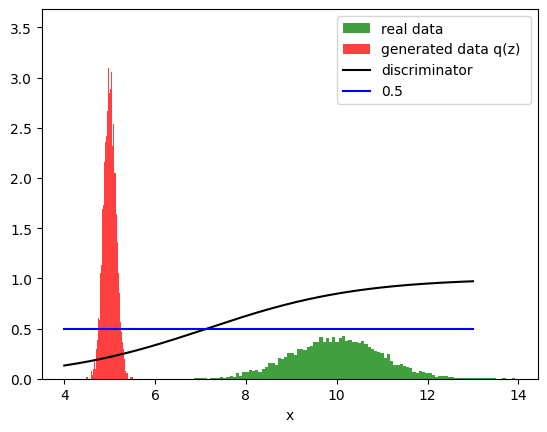

In [28]:
generator=make_generator_model()
generator= models.load_model('generator')
xhat=generator(z)
discriminator=models.load_model('discriminator')
plot_distribution(real_data=X,generated_data=xhat,discriminator=discriminator )

## Deep Convolutional Generative Adversarial Networks (DCGANs)


In the case example, you work for an online anime video game company; the company would like to create a unique anime avatar for a game for each player. As there are millions of players, you must use a DCGANs to create each character.

The proposed approaches are summarized here:

- Replace any pooling layers with **strided convolutions (discriminator)** and **fractional-strided
convolutions (generator)**.
- Use **batchnorm** in both the generator and the discriminator.
- **Remove fully connected hidden layers** for deeper architectures.
- Use **ReLU** activation in generator for all layers except for the output, which uses **Tanh**.
- Use **LeakyReLU** activation in the discriminator for all layers except for the output, which uses **Sigmoid**.
- Use **Adam optimizer**.  

These approaches will result in more stable training of deeper generative models.


### Loading the Dataset

We will mainly work with the Anime Face dataset from [Kaggle](https://www.kaggle.com/datasets/splcher/animefacedataset?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0XCEEN72-2022-01-01). The original dataset has 63,632 "high-quality" anime faces, but to make the models train faster in this lab, we randomly sampled 20,000 images and prepared a dataset called `cartoon_20000`.

Let's download the smaller dataset using the Skills Network library's `prepare` function:


In [29]:
dataset_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML311-Coursera/labs/Module6/cartoon_20000.zip"
await skillsnetwork.prepare(dataset_url, overwrite=True)

  0%|          | 0/20001 [00:00<?, ?it/s]

Saved to '.'


### Creating Data Generator


In [30]:
img_height, img_width, batch_size=64,64,128

In [31]:
train_ds = tf.keras.utils.image_dataset_from_directory(directory='cartoon_20000',
                                                       image_size=(img_height, img_width),
                                                       batch_size=batch_size,
                                                       label_mode=None)

Found 20000 files belonging to 1 classes.


In [32]:
#AUTOTUNE = tf.data.experimental.AUTOTUNE

#train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

In [33]:
normalization_layer = layers.experimental.preprocessing.Rescaling(scale= 1./127.5, offset=-1)
normalized_ds = train_ds.map(lambda x: normalization_layer(x))

In [34]:
images=train_ds.take(1)

In [35]:
X=[x for x in images]

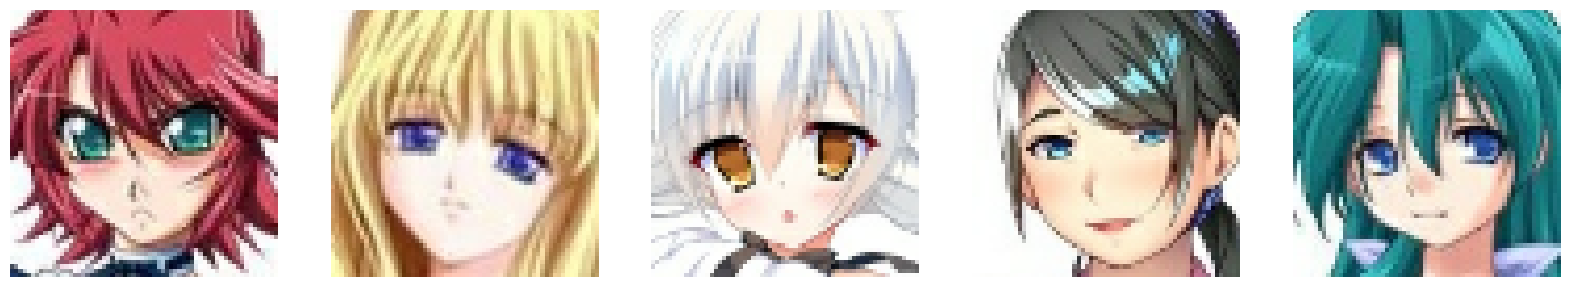

In [36]:
plot_array(X[0])

###  Generator and Discriminator (for DCGANs)


The Generator is comprised of several layers of transposed convolution, the opposite of convolution operations.

- Each Conv2DTranspose layer (except the final layer) is followed by a Batch Normalization layer and a **Relu activation**; for more implementation details, check out <a href="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/papers/1511.06434.pdf">[2]</a>.
- The final transpose convolution layer has three output channels since the output needs to be a color image. We use the **Tanh activation** in the final layer.

See the illustration of the architecture from <a href="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/papers/1511.06434.pdf">[2]</a> below.

<center><img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/images/generator.png" alt="generator image" width="80%"></center>


We build the Generator network by using the parameter values from <a href="https://learnopencv.com/deep-convolutional-gan-in-pytorch-and-tensorflow/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0XCEEN72-2022-01-01" >[3]<a>.


In [37]:
def make_generator():

    model=Sequential()

    # input is latent vector of 100 dimensions
    model.add(Input(shape=(1, 1, 100), name='input_layer'))

    # Block 1 dimensionality of the output space  64 * 8
    model.add(Conv2DTranspose(64 * 8, kernel_size=4, strides= 4, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_1'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(ReLU(name='relu_1'))

    # Block 2: input is 4 x 4 x (64 * 8)
    model.add(Conv2DTranspose(64 * 4, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(ReLU(name='relu_2'))

    # Block 3: input is 8 x 8 x (64 * 4)
    model.add(Conv2DTranspose(64 * 2, kernel_size=4,strides=  2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_3'))
    model.add(ReLU(name='relu_3'))


    # Block 4: input is 16 x 16 x (64 * 2)
    model.add(Conv2DTranspose(64 * 1, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_transpose_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8,  center=1.0, scale=0.02, name='bn_4'))
    model.add(ReLU(name='relu_4'))

    model.add(Conv2DTranspose(3, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False,
                              activation='tanh', name='conv_transpose_5'))

    return model

___Building the Discriminator___


In [38]:
def make_discriminator():

    model=Sequential()

    # Block 1: input is 64 x 64 x (3)
    model.add(Input(shape=(64, 64, 3), name='input_layer'))
    model.add(Conv2D(64, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_1'))

    # Block 2: input is 32 x 32 x (64)
    model.add(Conv2D(64 * 2, kernel_size=4, strides= 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_2'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_1'))
    model.add(LeakyReLU(0.2, name='leaky_relu_2'))

    # Block 3
    model.add(Conv2D(64 * 4, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_3'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_2'))
    model.add(LeakyReLU(0.2, name='leaky_relu_3'))


    #Block 4
    model.add(Conv2D(64 * 8, 4, 2, padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False, name='conv_4'))
    model.add(BatchNormalization(momentum=0.1,  epsilon=0.8, center=1.0, scale=0.02, name='bn_3'))
    model.add(LeakyReLU(0.2, name='leaky_relu_4'))


    #Block 5
    model.add(Conv2D(1, 4, 2,padding='same', kernel_initializer=tf.keras.initializers.RandomNormal(mean=0.0, stddev=0.02), use_bias=False,
                     activation='sigmoid', name='conv_5'))

    return model

In [39]:
disc = make_discriminator()
disc.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 32, 32, 64)        3072      
                                                                 
 leaky_relu_1 (LeakyReLU)    (None, 32, 32, 64)        0         
                                                                 
 conv_2 (Conv2D)             (None, 16, 16, 128)       131072    
                                                                 
 bn_1 (BatchNormalization)   (None, 16, 16, 128)       512       
                                                                 
 leaky_relu_2 (LeakyReLU)    (None, 16, 16, 128)       0         
                                                                 
 conv_3 (Conv2D)             (None, 8, 8, 256)         524288    
                                                                 
 bn_2 (BatchNormalization)   (None, 8, 8, 256)        

### Defining Loss Functions

As we discussed in the previous section, the min-max optimization problem can be formulated by minimizing the cross entropy loss for the Generator and Discriminator.  

The `cross_entropy` object is the Binary Cross Entropy loss that will be used to model the objectives of the two networks.


In [40]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [41]:
def generator_loss(Xhat):
    return cross_entropy(tf.ones_like(Xhat), Xhat)

In [42]:
def discriminator_loss(X, Xhat):
    real_loss = cross_entropy(tf.ones_like(X), X)
    fake_loss = cross_entropy(tf.zeros_like(Xhat), Xhat)
    total_loss = 0.5*(real_loss + fake_loss)
    return total_loss

### Defining Optimizers

We create two Adam optimizers for the discriminator and the generator, respectively. We pass the following arguments to the optimizers:

- learning rate of 0.0002.
- beta coefficients $\beta_1 = 0.5$ and $\beta_2 = 0.999$, which are responsible for computing the running averages of the gradients during backpropagation.


In [43]:
learning_rate = 0.0002

generator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

discriminator_optimizer = tf.keras.optimizers.Adam(lr = 0.0002, beta_1 = 0.5, beta_2 = 0.999 )

### Create Train Step Function

As this lab is more computationally intensive than the last lab, we convert the training step into a function and then use the  @tf.function decorator, which allows the function to be "compiled" into a **callable TensorFlow graph**. This will speed up the training; for more information, read <a href="https://www.tensorflow.org/guide/function?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkGuidedProjectsIBMGPXX0XCEEN72-2022-01-01">here </a>


In [44]:
@tf.function

def train_step(X):

    #random samples it was found if you increase the  stander deviation, you get better results
    z= tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
      # needed to compute the gradients for a list of variables.
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        #generated sample
        xhat = generator(z, training=True)
        #the output of the discriminator for real data
        real_output = discriminator(X, training=True)
        #the output of the discriminator for fake data
        fake_output = discriminator(xhat, training=True)

        #loss for each
        gen_loss= generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
      # Compute the gradients for gen_loss and generator

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    # Compute the gradients for gen_loss and discriminator
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Ask the optimizer to apply the processed gradients
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

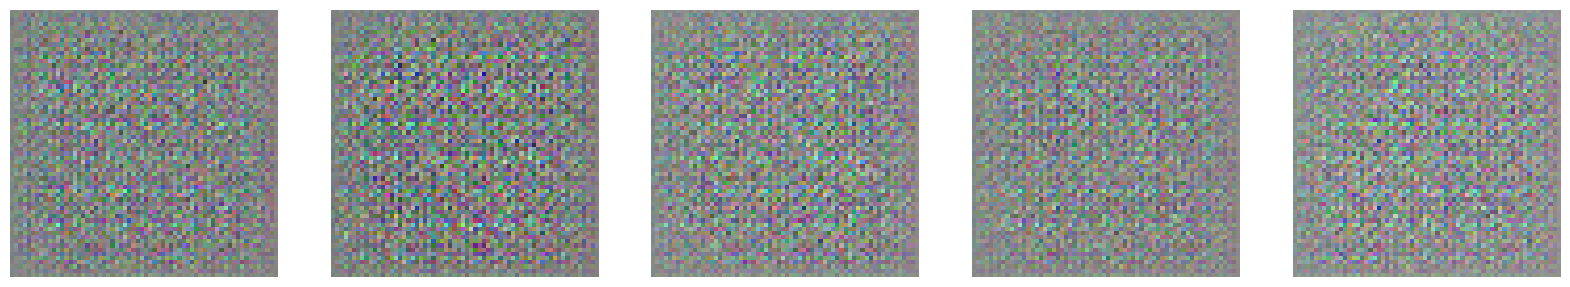

In [45]:
generator= make_generator()
BATCH_SIZE=128

latent_dim=100
noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
Xhat=generator(noise,training=False)
plot_array(Xhat)

### Training DCGANs


epoch 1:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 1, iteration 1


epoch 1:   1%|▏         | 2/157 [00:02<02:32,  1.02it/s]

epoch 1, iteration 2
epoch 1, iteration 3


epoch 1:   2%|▏         | 3/157 [00:02<01:35,  1.61it/s]

epoch 1, iteration 4


epoch 1:   3%|▎         | 5/157 [00:02<00:55,  2.75it/s]

epoch 1, iteration 5
epoch 1, iteration 6


epoch 1:   4%|▍         | 7/157 [00:03<00:40,  3.74it/s]

epoch 1, iteration 7
epoch 1, iteration 8


epoch 1:   6%|▌         | 9/157 [00:03<00:34,  4.31it/s]

epoch 1, iteration 9


epoch 1:   6%|▋         | 10/157 [00:03<00:32,  4.57it/s]

epoch 1, iteration 10
epoch 1, iteration 11


epoch 1:   8%|▊         | 12/157 [00:04<00:29,  4.96it/s]

epoch 1, iteration 12
epoch 1, iteration 13


epoch 1:   9%|▉         | 14/157 [00:04<00:28,  5.11it/s]

epoch 1, iteration 14
epoch 1, iteration 15

epoch 1:  10%|▉         | 15/157 [00:04<00:27,  5.14it/s]


epoch 1, iteration 16


epoch 1:  11%|█         | 17/157 [00:05<00:26,  5.24it/s]

epoch 1, iteration 17
epoch 1, iteration 18


epoch 1:  12%|█▏        | 19/157 [00:05<00:26,  5.18it/s]

epoch 1, iteration 19
epoch 1, iteration 20


epoch 1:  13%|█▎        | 21/157 [00:05<00:25,  5.26it/s]

epoch 1, iteration 21
epoch 1, iteration 22


epoch 1:  15%|█▍        | 23/157 [00:06<00:25,  5.30it/s]

epoch 1, iteration 23
epoch 1, iteration 24


epoch 1:  16%|█▌        | 25/157 [00:06<00:25,  5.25it/s]

epoch 1, iteration 25
epoch 1, iteration 26


epoch 1:  17%|█▋        | 27/157 [00:07<00:24,  5.29it/s]

epoch 1, iteration 27
epoch 1, iteration 28


epoch 1:  18%|█▊        | 29/157 [00:07<00:23,  5.36it/s]

epoch 1, iteration 29
epoch 1, iteration 30


epoch 1:  19%|█▉        | 30/157 [00:07<00:23,  5.31it/s]

epoch 1, iteration 31


epoch 1:  20%|█▉        | 31/157 [00:07<00:25,  4.93it/s]

epoch 1, iteration 32


epoch 1:  20%|██        | 32/157 [00:08<00:26,  4.70it/s]

epoch 1, iteration 33


epoch 1:  21%|██        | 33/157 [00:08<00:27,  4.53it/s]

epoch 1, iteration 34


epoch 1:  22%|██▏       | 34/157 [00:08<00:27,  4.41it/s]

epoch 1, iteration 35


epoch 1:  22%|██▏       | 35/157 [00:08<00:28,  4.31it/s]

epoch 1, iteration 36


epoch 1:  23%|██▎       | 36/157 [00:09<00:27,  4.33it/s]

epoch 1, iteration 37


epoch 1:  24%|██▎       | 37/157 [00:09<00:27,  4.29it/s]

epoch 1, iteration 38


epoch 1:  24%|██▍       | 38/157 [00:09<00:28,  4.17it/s]

epoch 1, iteration 39


epoch 1:  25%|██▍       | 39/157 [00:09<00:29,  4.04it/s]

epoch 1, iteration 40


epoch 1:  26%|██▌       | 41/157 [00:10<00:27,  4.25it/s]

epoch 1, iteration 41
epoch 1, iteration 42


epoch 1:  27%|██▋       | 43/157 [00:10<00:24,  4.72it/s]

epoch 1, iteration 43
epoch 1, iteration 44


epoch 1:  29%|██▊       | 45/157 [00:11<00:22,  5.08it/s]

epoch 1, iteration 45
epoch 1, iteration 46


epoch 1:  30%|██▉       | 47/157 [00:11<00:20,  5.27it/s]

epoch 1, iteration 47
epoch 1, iteration 48


epoch 1:  31%|███       | 49/157 [00:11<00:20,  5.33it/s]

epoch 1, iteration 49
epoch 1, iteration 50


epoch 1:  32%|███▏      | 51/157 [00:12<00:20,  5.26it/s]

epoch 1, iteration 51
epoch 1, iteration 52


epoch 1:  34%|███▍      | 53/157 [00:12<00:19,  5.22it/s]

epoch 1, iteration 53
epoch 1, iteration 54


epoch 1:  35%|███▌      | 55/157 [00:12<00:19,  5.26it/s]

epoch 1, iteration 55
epoch 1, iteration 56


epoch 1:  36%|███▋      | 57/157 [00:13<00:18,  5.30it/s]

epoch 1, iteration 57
epoch 1, iteration 58


epoch 1:  38%|███▊      | 59/157 [00:13<00:18,  5.29it/s]

epoch 1, iteration 59
epoch 1, iteration 60


epoch 1:  38%|███▊      | 60/157 [00:13<00:18,  5.35it/s]

epoch 1, iteration 61


epoch 1:  39%|███▉      | 62/157 [00:14<00:18,  5.16it/s]

epoch 1, iteration 62


epoch 1:  40%|████      | 63/157 [00:14<00:18,  5.18it/s]

epoch 1, iteration 63
epoch 1, iteration 64


epoch 1:  41%|████▏     | 65/157 [00:14<00:17,  5.27it/s]

epoch 1, iteration 65
epoch 1, iteration 66


epoch 1:  43%|████▎     | 67/157 [00:15<00:17,  5.17it/s]

epoch 1, iteration 67
epoch 1, iteration 68


epoch 1:  44%|████▍     | 69/157 [00:15<00:16,  5.25it/s]

epoch 1, iteration 69
epoch 1, iteration 70


epoch 1:  45%|████▌     | 71/157 [00:15<00:16,  5.24it/s]

epoch 1, iteration 71
epoch 1, iteration 72


epoch 1:  46%|████▋     | 73/157 [00:16<00:15,  5.36it/s]

epoch 1, iteration 73
epoch 1, iteration 74


epoch 1:  48%|████▊     | 75/157 [00:16<00:15,  5.35it/s]

epoch 1, iteration 75
epoch 1, iteration 76


epoch 1:  49%|████▉     | 77/157 [00:17<00:15,  5.22it/s]

epoch 1, iteration 77
epoch 1, iteration 78


epoch 1:  50%|█████     | 79/157 [00:17<00:14,  5.20it/s]

epoch 1, iteration 79
epoch 1, iteration 80


epoch 1:  52%|█████▏    | 81/157 [00:17<00:14,  5.31it/s]

epoch 1, iteration 81
epoch 1, iteration 82


epoch 1:  53%|█████▎    | 83/157 [00:18<00:14,  5.25it/s]

epoch 1, iteration 83
epoch 1, iteration 84


epoch 1:  54%|█████▍    | 85/157 [00:18<00:13,  5.24it/s]

epoch 1, iteration 85
epoch 1, iteration 86


epoch 1:  55%|█████▌    | 87/157 [00:19<00:13,  5.30it/s]

epoch 1, iteration 87
epoch 1, iteration 88


epoch 1:  57%|█████▋    | 89/157 [00:19<00:12,  5.25it/s]

epoch 1, iteration 89
epoch 1, iteration 90


epoch 1:  58%|█████▊    | 91/157 [00:19<00:12,  5.33it/s]

epoch 1, iteration 91
epoch 1, iteration 92


epoch 1:  59%|█████▊    | 92/157 [00:19<00:12,  5.31it/s]

epoch 1, iteration 93


epoch 1:  59%|█████▉    | 93/157 [00:20<00:13,  4.89it/s]

epoch 1, iteration 94


epoch 1:  60%|█████▉    | 94/157 [00:20<00:14,  4.38it/s]

epoch 1, iteration 95


epoch 1:  61%|██████    | 95/157 [00:20<00:14,  4.16it/s]

epoch 1, iteration 96


epoch 1:  61%|██████    | 96/157 [00:21<00:15,  4.05it/s]

epoch 1, iteration 97


epoch 1:  62%|██████▏   | 97/157 [00:21<00:14,  4.00it/s]

epoch 1, iteration 98


epoch 1:  62%|██████▏   | 98/157 [00:21<00:15,  3.87it/s]

epoch 1, iteration 99


epoch 1:  63%|██████▎   | 99/157 [00:21<00:14,  3.90it/s]

epoch 1, iteration 100


epoch 1:  64%|██████▎   | 100/157 [00:22<00:15,  3.77it/s]

epoch 1, iteration 101


epoch 1:  64%|██████▍   | 101/157 [00:22<00:15,  3.62it/s]

epoch 1, iteration 102


epoch 1:  66%|██████▌   | 103/157 [00:22<00:12,  4.21it/s]

epoch 1, iteration 103
epoch 1, iteration 104


epoch 1:  66%|██████▌   | 104/157 [00:23<00:11,  4.48it/s]

epoch 1, iteration 105


epoch 1:  68%|██████▊   | 106/157 [00:23<00:10,  4.76it/s]

epoch 1, iteration 106
epoch 1, iteration 107


epoch 1:  69%|██████▉   | 108/157 [00:23<00:09,  4.99it/s]

epoch 1, iteration 108
epoch 1, iteration 109


epoch 1:  70%|███████   | 110/157 [00:24<00:09,  5.11it/s]

epoch 1, iteration 110
epoch 1, iteration 111


epoch 1:  71%|███████▏  | 112/157 [00:24<00:09,  4.98it/s]

epoch 1, iteration 112
epoch 1, iteration 113

epoch 1:  72%|███████▏  | 113/157 [00:24<00:08,  5.03it/s]


epoch 1, iteration 114


epoch 1:  73%|███████▎  | 115/157 [00:25<00:08,  5.11it/s]

epoch 1, iteration 115
epoch 1, iteration 116


epoch 1:  75%|███████▍  | 117/157 [00:25<00:07,  5.09it/s]

epoch 1, iteration 117
epoch 1, iteration 118


epoch 1:  76%|███████▌  | 119/157 [00:25<00:07,  5.02it/s]

epoch 1, iteration 119
epoch 1, iteration 120


epoch 1:  77%|███████▋  | 121/157 [00:26<00:07,  4.99it/s]

epoch 1, iteration 121


epoch 1:  78%|███████▊  | 122/157 [00:26<00:06,  5.02it/s]

epoch 1, iteration 122
epoch 1, iteration 123


epoch 1:  79%|███████▉  | 124/157 [00:26<00:06,  5.15it/s]

epoch 1, iteration 124
epoch 1, iteration 125


epoch 1:  80%|████████  | 126/157 [00:27<00:06,  5.11it/s]

epoch 1, iteration 126


epoch 1:  81%|████████  | 127/157 [00:27<00:05,  5.18it/s]

epoch 1, iteration 127
epoch 1, iteration 128


epoch 1:  82%|████████▏ | 129/157 [00:27<00:05,  5.17it/s]

epoch 1, iteration 129
epoch 1, iteration 130


epoch 1:  83%|████████▎ | 131/157 [00:28<00:05,  5.19it/s]

epoch 1, iteration 131
epoch 1, iteration 132


epoch 1:  85%|████████▍ | 133/157 [00:28<00:04,  5.17it/s]

epoch 1, iteration 133
epoch 1, iteration 134


epoch 1:  86%|████████▌ | 135/157 [00:29<00:04,  5.21it/s]

epoch 1, iteration 135
epoch 1, iteration 136


epoch 1:  87%|████████▋ | 137/157 [00:29<00:03,  5.17it/s]

epoch 1, iteration 137
epoch 1, iteration 138


epoch 1:  89%|████████▊ | 139/157 [00:29<00:03,  5.28it/s]

epoch 1, iteration 139
epoch 1, iteration 140


epoch 1:  90%|████████▉ | 141/157 [00:30<00:03,  5.29it/s]

epoch 1, iteration 141
epoch 1, iteration 142


epoch 1:  91%|█████████ | 143/157 [00:30<00:02,  5.18it/s]

epoch 1, iteration 143
epoch 1, iteration 144


epoch 1:  92%|█████████▏| 145/157 [00:30<00:02,  5.24it/s]

epoch 1, iteration 145
epoch 1, iteration 146


epoch 1:  94%|█████████▎| 147/157 [00:31<00:01,  5.33it/s]

epoch 1, iteration 147
epoch 1, iteration 148


epoch 1:  95%|█████████▍| 149/157 [00:31<00:01,  5.48it/s]

epoch 1, iteration 149
epoch 1, iteration 150


epoch 1:  96%|█████████▌| 151/157 [00:32<00:01,  5.46it/s]

epoch 1, iteration 151
epoch 1, iteration 152


epoch 1:  97%|█████████▋| 153/157 [00:32<00:00,  5.36it/s]

epoch 1, iteration 153
epoch 1, iteration 154


epoch 1:  98%|█████████▊| 154/157 [00:32<00:00,  4.88it/s]

epoch 1, iteration 155


epoch 1:  99%|█████████▊| 155/157 [00:32<00:00,  4.74it/s]

epoch 1, iteration 156


epoch 1:  99%|█████████▉| 156/157 [00:33<00:00,  4.68it/s]

epoch 1, iteration 157


epoch 1: 100%|██████████| 157/157 [00:34<00:00,  4.60it/s]


orignal images


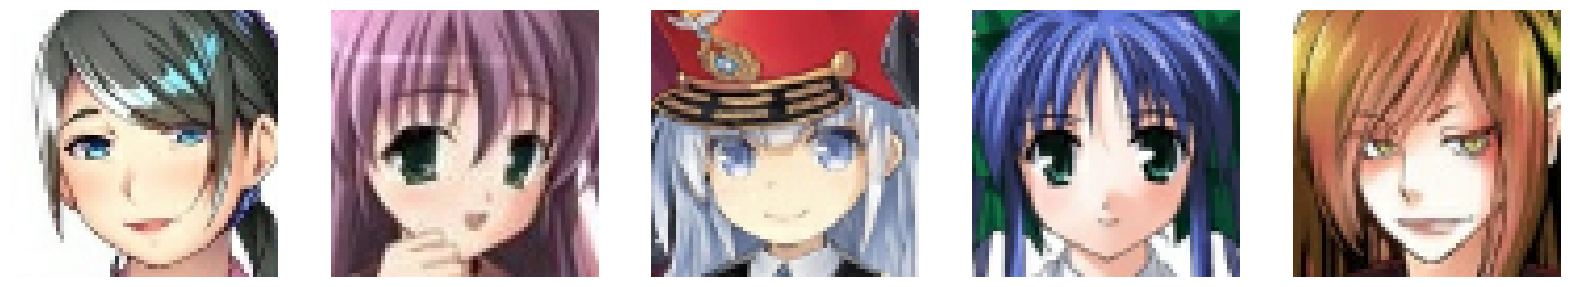

generated images


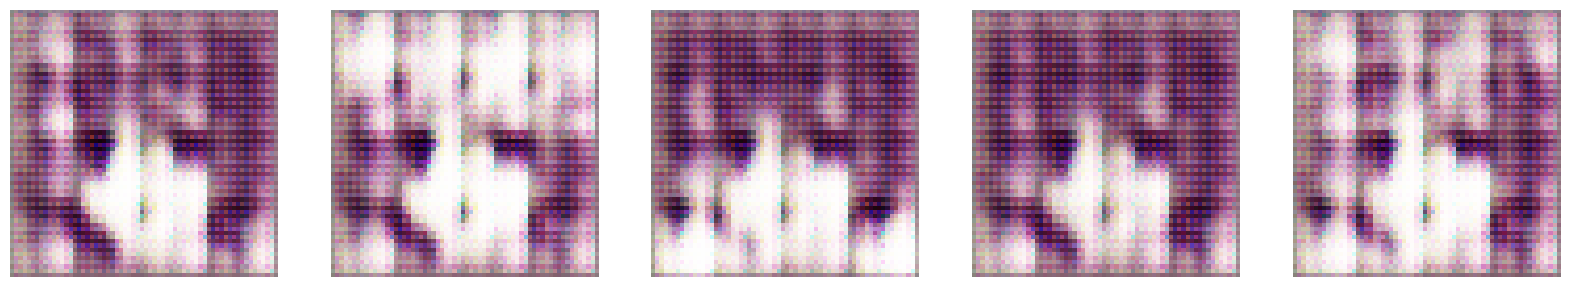

Time for epoch 1 is 38.662890672683716 sec


In [46]:
epochs=1

discriminator=make_discriminator()

generator= make_generator()


for epoch in range(epochs):

    #data for the true distribution of your real data samples training ste
    start = time.time()
    i=0
    for X in tqdm(normalized_ds, desc=f"epoch {epoch+1}", total=len(normalized_ds)):

        i+=1
        if i%1000:
            print("epoch {}, iteration {}".format(epoch+1, i))

        train_step(X)


    noise = tf.random.normal([BATCH_SIZE, 1, 1, latent_dim])
    Xhat=generator(noise,training=False)
    X=[x for x in normalized_ds]
    print("orignal images")
    plot_array(X[0])
    print("generated images")
    plot_array(Xhat)
    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

___Loading Pre-trained model (150 epochs)___


In [47]:
generator_url="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-GPXX0XCEEN/data/generator.tar"
await skillsnetwork.prepare(generator_url, overwrite=True)

  0%|          | 0/7 [00:00<?, ?it/s]

Saved to '.'


In [48]:
from tensorflow.keras.models import load_model


full_generator=load_model("generator")

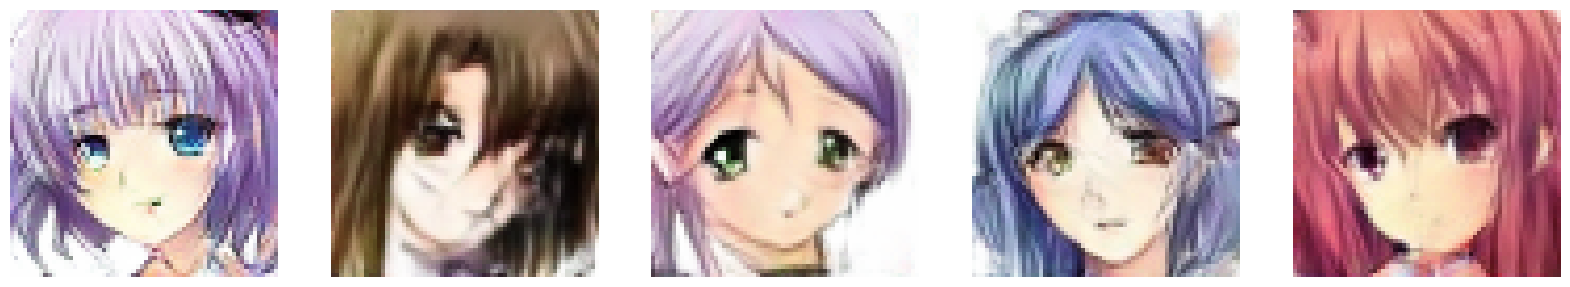

In [49]:
latent_dim=100

# input consists of noise vectors
noise = tf.random.normal([200, 1, 1, latent_dim])

# feed the noise vectors to the generator
Xhat=full_generator(noise,training=False)
plot_array(Xhat)

## Explore Latent Variables

Values of $\mathbf{z}$ that are relatively close together will produce similar images. For example, we can assigns elements of $\mathbf{z}$ close values such as $[1,0.8,..,0.4]$.


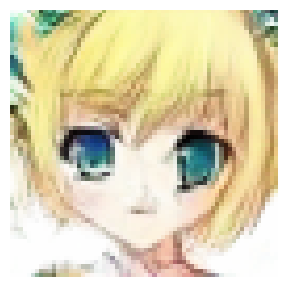

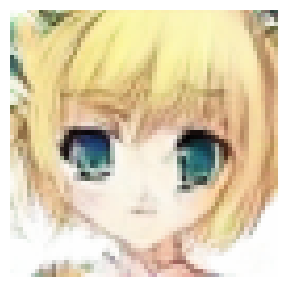

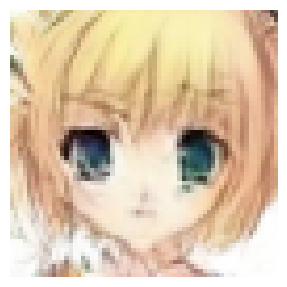

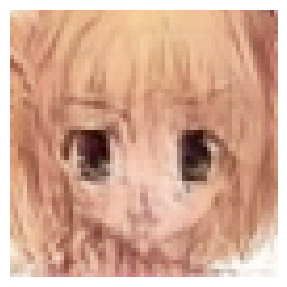

In [50]:
for c in [1,0.8,0.6,0.4]:
    Xhat=full_generator(c*tf.ones([1, 1, 1, latent_dim]),training=False) # latent_dim = 100 defined previously
    plot_array(Xhat)

### Exercise 1

Plot the generated images by the Generator with elements of $\mathbf{z}$ equal $[-1,-0.8,-0.6,-0.4]$.


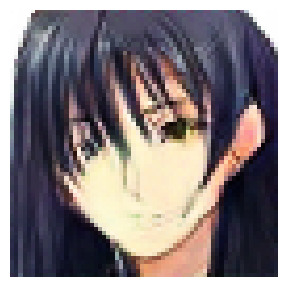

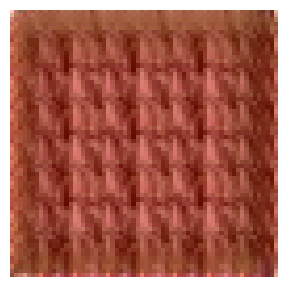

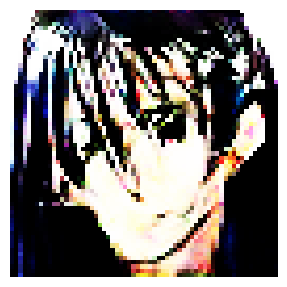

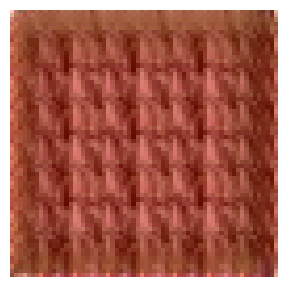

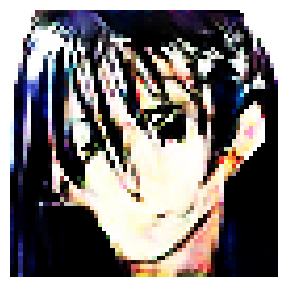

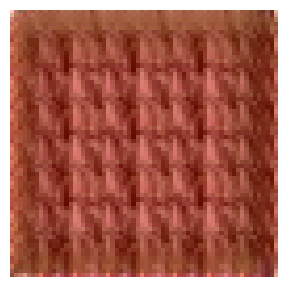

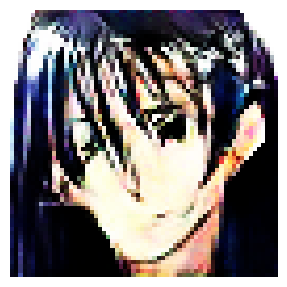

In [53]:
for c in [1,0,8,0,6,0,4]:
  Xhat = full_generator(-c*tf.ones([1, 1, 1, latent_dim]),training=False)
  plot_array(Xhat)

elements from 0 to 0 is set to -1


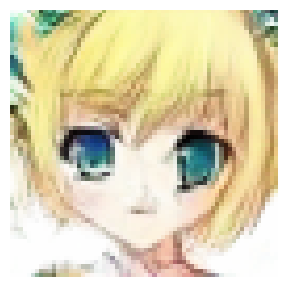

elements from 0 to 10 is set to -1


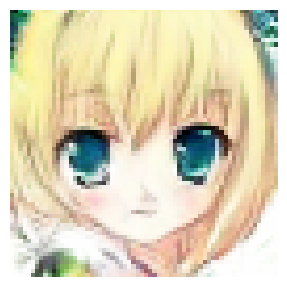

elements from 0 to 20 is set to -1


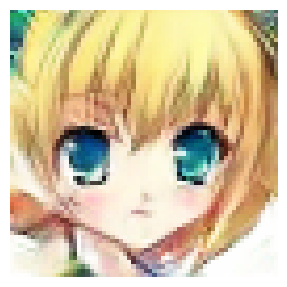

elements from 0 to 30 is set to -1


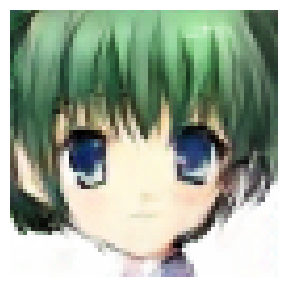

elements from 0 to 40 is set to -1


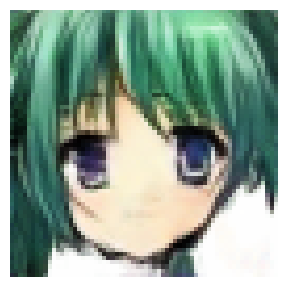

elements from 0 to 50 is set to -1


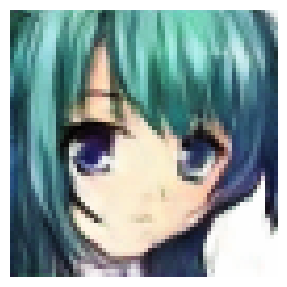

elements from 0 to 60 is set to -1


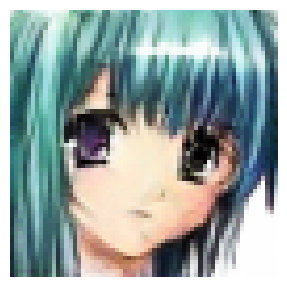

elements from 0 to 70 is set to -1


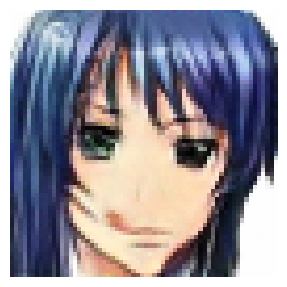

elements from 0 to 80 is set to -1


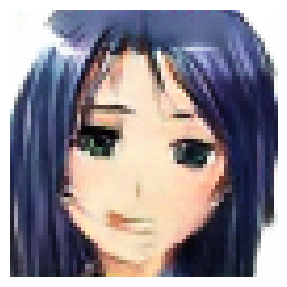

elements from 0 to 90 is set to -1


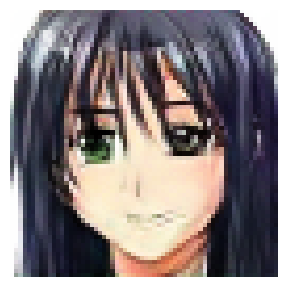

In [51]:
z=np.ones( (1, 1, 1, latent_dim))
for n in range(10):

    z[0, 0, 0, 0:10*n]=-1

    Xhat=full_generator(z,training=False)
    print("elements from 0 to {} is set to -1".format(10*n))
    plot_array(Xhat)

### Exercise 2

Repeat the above procedure but set the latent variable $z[0, 0, 0, 0:20*n] = -0.5*n$ each time `for n in range(5)`


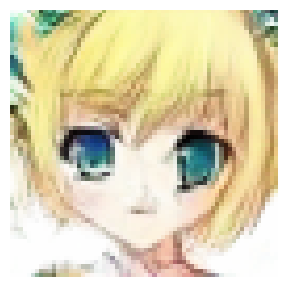

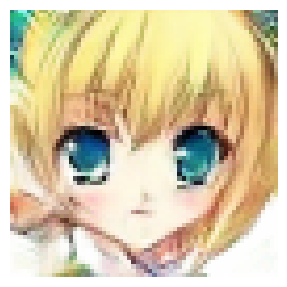

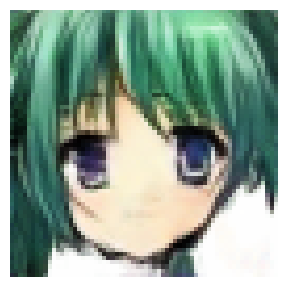

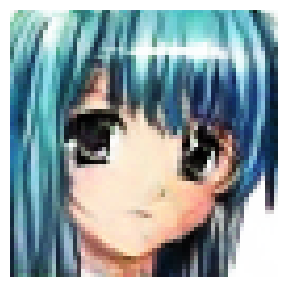

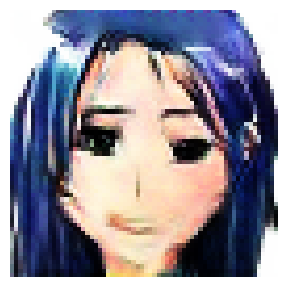

In [54]:
z=np.ones((1,1,1, latent_dim))
for n in range(5):
  z[0, 0, 0, 0:20*n]=-0.5*n

  Xhat=full_generator(z,training=False)
  plot_array(Xhat)

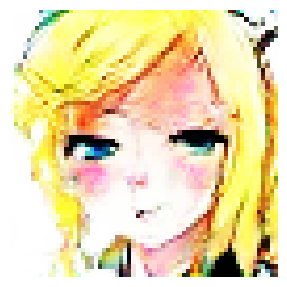

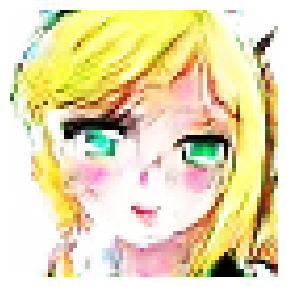

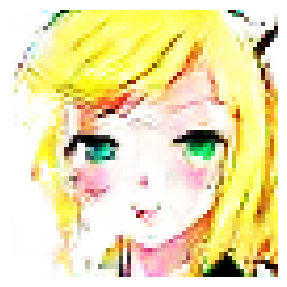

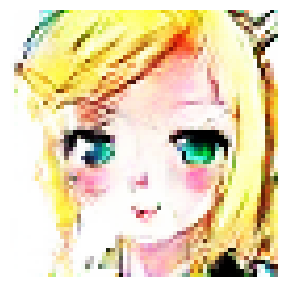

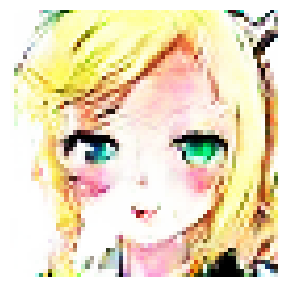

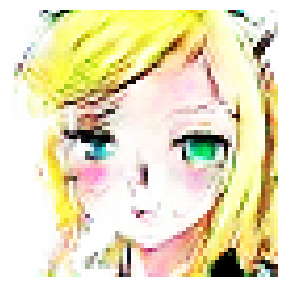

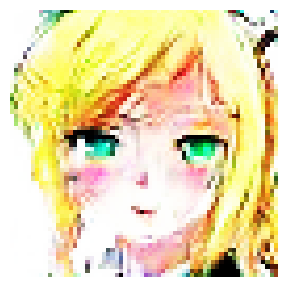

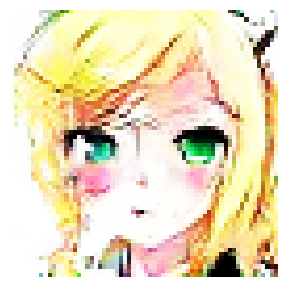

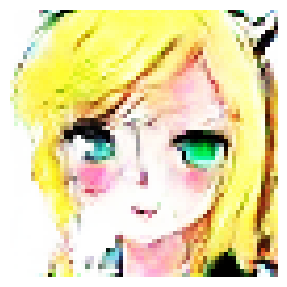

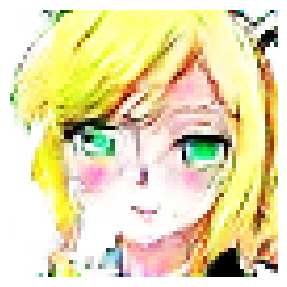

In [52]:
for n in range(10):
    z=np.random.normal(0, 1, (1, 1, 1, latent_dim))

    z[0,0,0,0:35]=7

    Xhat=full_generator(z,training=False)

    plot_array(Xhat)

### Exercise 3

Repeat the procedure above, but set the elements of $\mathbf{z}$ from index 0 to 35 to -1


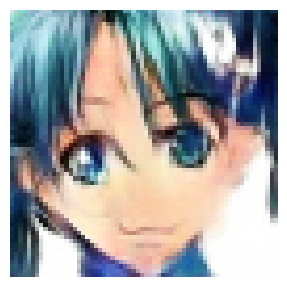

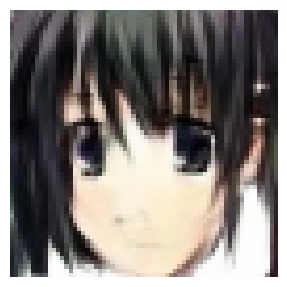

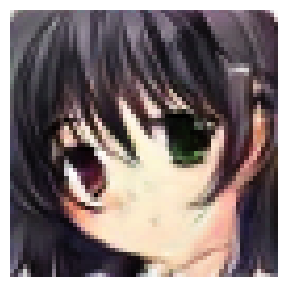

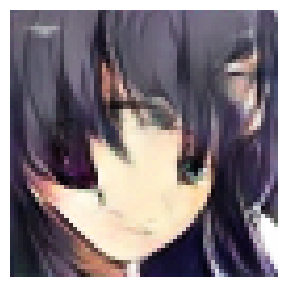

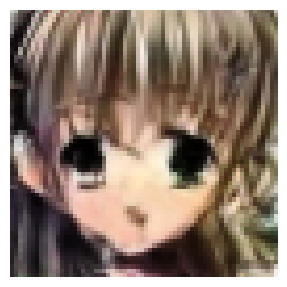

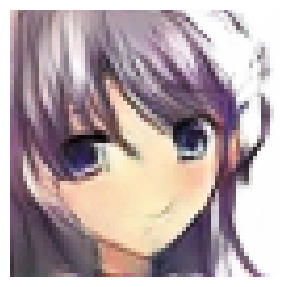

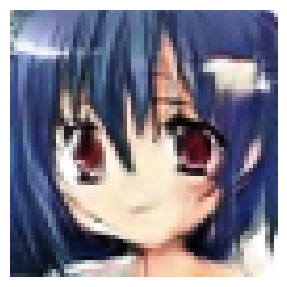

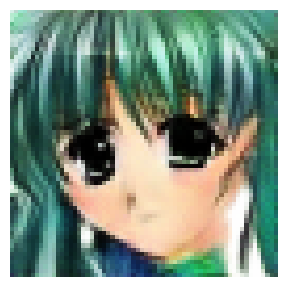

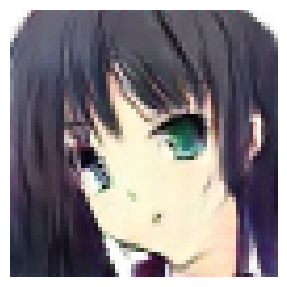

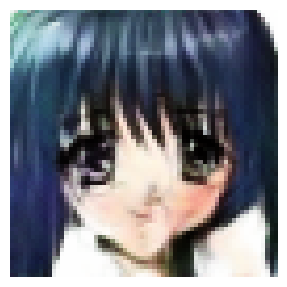

In [56]:
for n in range(10):
  z=np.random.normal(0, 1,(1, 1, 1, latent_dim))

  z[0, 0, 0, 0:35]=-1

  Xhat=full_generator(z, training=False)

  plot_array(Xhat)